  method color_space  average_psnr  average_ssim
0     HE   grayscale      8.894570      0.227058
1     HE       color      8.977763      0.226548
2  CLAHE   grayscale     25.175466      0.839225
3  CLAHE       color     25.167423      0.834887


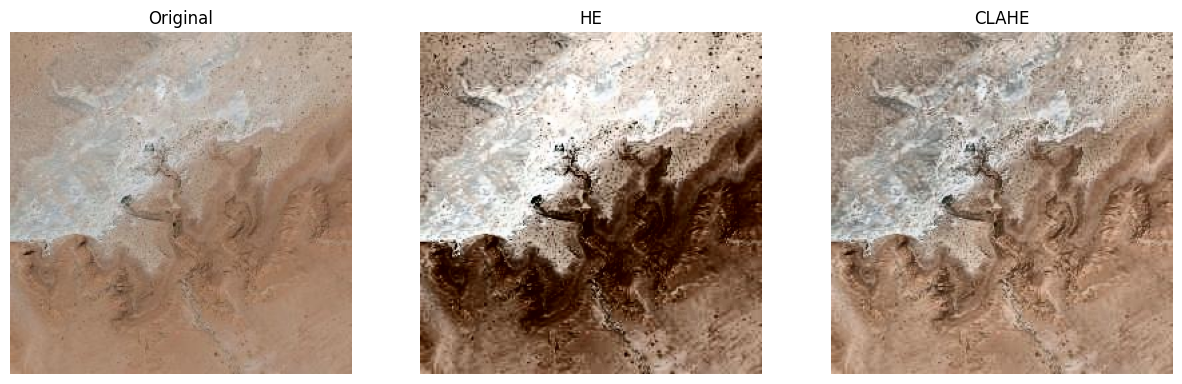

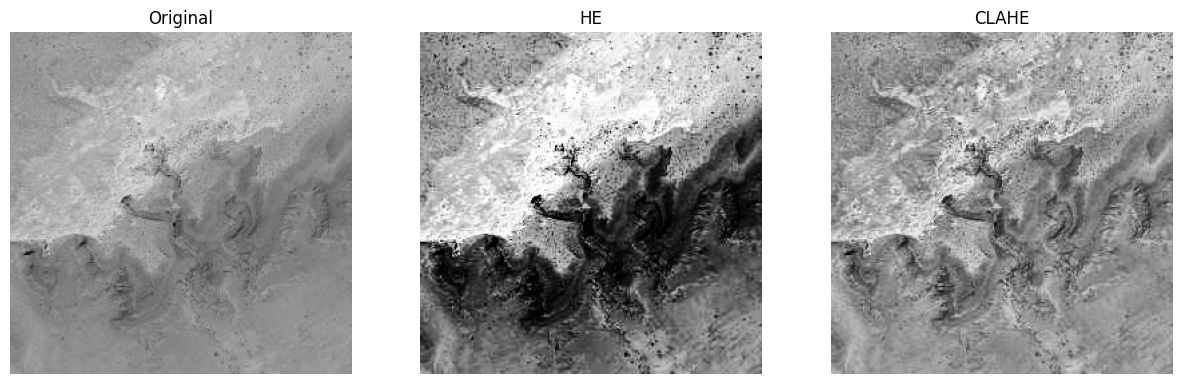

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
import math

def calculate_psnr(original, enhanced):
    mse = np.mean((original.astype(np.float64) - enhanced.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr_value

def calculate_ssim(original, enhanced):
    min_dimension = min(original.shape[:2])  
    win_size = min(3, min_dimension)  
    
    if len(original.shape) == 3:  
        ssim_value = ssim(
            original,
            enhanced,
            multichannel=True,
            channel_axis=-1,
            win_size=win_size
        )
    else:  
        ssim_value = ssim(
            original,
            enhanced,
            win_size=win_size
        )
    return ssim_value


def process_image(image_path, method='HE', color_space='grayscale'):
    if color_space == 'grayscale':
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if image is None:
        print(f"Failed to load image {image_path}")
        return None, None, None, None
    if method == 'HE':
        enhanced_image = apply_he(image, color_space)
    elif method == 'CLAHE':
        enhanced_image = apply_clahe(image, color_space)
    else:
        raise ValueError("Invalid method. Choose 'HE' or 'CLAHE'.")
    psnr_value = calculate_psnr(image, enhanced_image)
    ssim_value = calculate_ssim(image, enhanced_image)
    
    return image, enhanced_image, psnr_value, ssim_value

def apply_he(image, color_space):
    if color_space == 'grayscale':
        enhanced = cv2.equalizeHist(image)
    else:
        img_y_cr_cb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        y_channel, cr, cb = cv2.split(img_y_cr_cb)
        y_channel_eq = cv2.equalizeHist(y_channel)
        img_y_cr_cb_eq = cv2.merge((y_channel_eq, cr, cb))
        enhanced = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCrCb2RGB)
    return enhanced
def apply_clahe(image, color_space):
    if color_space == 'grayscale':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(image)
    else:
        img_y_cr_cb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        y_channel, cr, cb = cv2.split(img_y_cr_cb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        y_channel_clahe = clahe.apply(y_channel)
        img_y_cr_cb_clahe = cv2.merge((y_channel_clahe, cr, cb))
        enhanced = cv2.cvtColor(img_y_cr_cb_clahe, cv2.COLOR_YCrCb2RGB)
    return enhanced

dataset_dir = 'data'  
classes = ['cloudy', 'desert', 'water', 'green_area']
methods = ['HE', 'CLAHE']
color_spaces = ['grayscale', 'color']

results = {method: {cs: [] for cs in color_spaces} for method in methods}

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    for filename in os.listdir(class_dir):
        image_path = os.path.join(class_dir, filename)
        for method in methods:
            for color_space in color_spaces:
                image, enhanced_image, psnr_value, ssim_value = process_image(image_path, method, color_space)
                if image is not None:
                    results[method][color_space].append({
                        'class': cls,
                        'filename': filename,
                        'psnr': psnr_value,
                        'ssim': ssim_value
                    })

for method in methods:
    for color_space in color_spaces:
        df = pd.DataFrame(results[method][color_space])
        csv_filename = f'results_{method}_{color_space}.csv'
        df.to_csv(csv_filename, index=False)
averages = []
for method in methods:
    for color_space in color_spaces:
        df = pd.DataFrame(results[method][color_space])
        avg_psnr = df['psnr'].mean()
        avg_ssim = df['ssim'].mean()
        averages.append({
            'method': method,
            'color_space': color_space,
            'average_psnr': avg_psnr,
            'average_ssim': avg_ssim
        })

averages_df = pd.DataFrame(averages)
print(averages_df)
def display_images(original, he_image, clahe_image, color_space):
    plt.figure(figsize=(15, 5))
    titles = ['Original', 'HE', 'CLAHE']
    images = [original, he_image, clahe_image]
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        if color_space == 'grayscale':
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

sample_image_path = os.path.join(dataset_dir, 'desert', 'desert(4).jpg')  
original_color = cv2.imread(sample_image_path)
original_color = cv2.cvtColor(original_color, cv2.COLOR_BGR2RGB)
original_gray = cv2.cvtColor(original_color, cv2.COLOR_RGB2GRAY)

he_color = apply_he(original_color, 'color')
clahe_color = apply_clahe(original_color, 'color')
he_gray = apply_he(original_gray, 'grayscale')
clahe_gray = apply_clahe(original_gray, 'grayscale')

display_images(original_color, he_color, clahe_color, 'color')

display_images(original_gray, he_gray, clahe_gray, 'grayscale')
